Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 280/280 [00:00<00:00, 8746.27 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_35052\3539696507.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.354500,0.321452,0.864286,0.862866
2,0.336000,0.257238,0.921429,0.921168
3,0.300300,0.239003,0.914286,0.914001
4,0.184200,0.411962,0.903571,0.903085
5,0.249800,0.432915,0.910714,0.910568
6,0.149400,0.574182,0.900000,0.902105
7,0.146600,0.547244,0.903571,0.904824
8,0.215200,0.559287,0.903571,0.904571
9,0.069100,0.536823,0.910714,0.911393
10,0.040900,0.535003,0.903571,0.904571


Evaluation results: {'eval_loss': 0.2390032559633255, 'eval_accuracy': 0.9142857142857143, 'eval_f1': 0.9140012928248221, 'eval_runtime': 1.6492, 'eval_samples_per_second': 169.783, 'eval_steps_per_second': 10.915, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.94      0.94       194
    Positive       0.87      0.85      0.86        86

    accuracy                           0.91       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.91      0.91      0.91       280



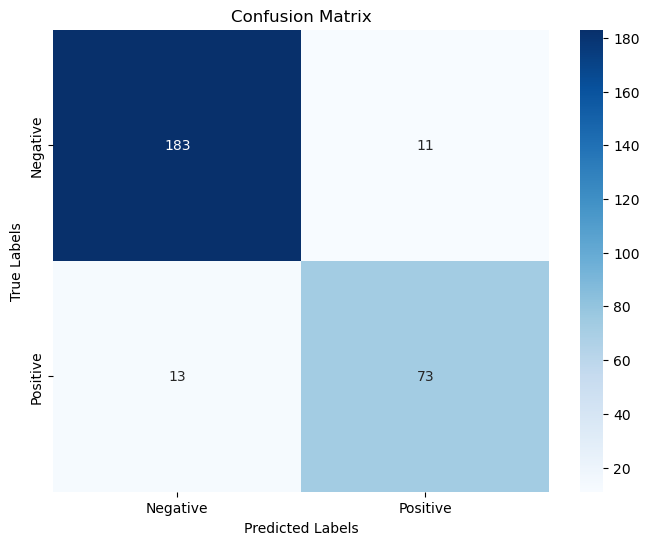

In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['Comment']
y = df['Label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlm-roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load Data
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
X, y = df['Comment'], df['Label']
le = LabelEncoder()
y_en = le.fit_transform(y)
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_en}))
data = data.train_test_split(test_size=0.2, seed=42)

# Tokenization
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)
data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text'])
data = data.rename_column('label', 'labels')
data.set_format('torch')

# Hyperparameter Grid
param_grid = {
    "learning_rate": [2e-5, 3e-5, 5e-5, 3e-6, 5e-6],
    "batch_size": [8, 16],
    "epochs": [3, 5, 7, 10],
    "weight_decay": [0.01, 0.1]
}

best_params = None
best_score = 0

device = torch.device('cuda')
for lr in param_grid["learning_rate"]:
    for bs in param_grid["batch_size"]:
        for ep in param_grid["epochs"]:
            for wd in param_grid["weight_decay"]:
                print(f"Training with lr={lr}, bs={bs}, epochs={ep}, weight_decay={wd}")
                
                model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
                model.to(device)
                
                training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=lr,
                    per_device_train_batch_size=bs,
                    per_device_eval_batch_size=bs,
                    num_train_epochs=ep,
                    weight_decay=wd,
                    logging_dir="./logs",
                    save_strategy='no',
                    report_to=[]
                )
                
                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=data['train'],
                    eval_dataset=data['test'],
                    tokenizer=tokenizer,
                    compute_metrics=lambda eval_pred: {
                        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
                        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
                    }
                )
                
                trainer.train()
                eval_results = trainer.evaluate()
                score = eval_results["eval_accuracy"]
                
                if score > best_score:
                    best_score = score
                    best_params = {"learning_rate": lr, "batch_size": bs, "epochs": ep, "weight_decay": wd}

print("Best hyperparameters: ", best_params)


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Map: 100%|██████████| 280/280 [00:00<00:00, 8832.31 examples/s]


Training with lr=2e-05, bs=8, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.297722,0.903571,0.903726
2,No log,0.378074,0.907143,0.906511
3,No log,0.403959,0.910714,0.911874


Training with lr=2e-05, bs=8, epochs=3, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.550788,0.692857,0.567149
2,No log,0.423894,0.842857,0.832868
3,No log,0.339593,0.867857,0.867191


Training with lr=2e-05, bs=8, epochs=5, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.469286,0.700000,0.583513
2,No log,0.338237,0.910714,0.911640
3,No log,0.384463,0.892857,0.891737
4,0.414400,0.414574,0.903571,0.903726
5,0.414400,0.455343,0.907143,0.907714


Training with lr=2e-05, bs=8, epochs=5, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.429391,0.832143,0.815198
2,No log,0.400663,0.878571,0.881596
3,No log,0.332024,0.917857,0.917723
4,0.363700,0.410691,0.917857,0.918924
5,0.363700,0.449986,0.917857,0.918241


Training with lr=2e-05, bs=8, epochs=7, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.385493,0.857143,0.856171
2,No log,0.423197,0.839286,0.837902
3,No log,0.401730,0.896429,0.896594
4,0.418200,0.391276,0.914286,0.914001
5,0.418200,0.415509,0.903571,0.905063
6,0.418200,0.380132,0.917857,0.918241
7,0.418200,0.483738,0.900000,0.901665


Training with lr=2e-05, bs=8, epochs=7, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.426323,0.832143,0.819900
2,No log,0.440275,0.896429,0.895907
3,No log,0.413815,0.903571,0.902741
4,0.371800,0.337259,0.925000,0.924877
5,0.371800,0.484557,0.917857,0.918709
6,0.371800,0.523444,0.896429,0.897502
7,0.371800,0.560538,0.896429,0.897502


Training with lr=2e-05, bs=8, epochs=10, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.281274,0.889286,0.887918
2,No log,0.397447,0.892857,0.890896
3,No log,0.235641,0.928571,0.928334
4,0.392900,0.473836,0.910714,0.908512
5,0.392900,0.471096,0.914286,0.915288
6,0.392900,0.504161,0.910714,0.911640
7,0.392900,0.469681,0.917857,0.917443
8,0.135500,0.517683,0.914286,0.915288
9,0.135500,0.552711,0.917857,0.918709
10,0.135500,0.556622,0.917857,0.918709


Training with lr=2e-05, bs=8, epochs=10, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.512952,0.692857,0.567149
2,No log,0.247432,0.903571,0.904571
3,No log,0.328725,0.907143,0.905443
4,0.422500,0.545866,0.892857,0.893821
5,0.422500,0.441850,0.925000,0.924354
6,0.422500,0.610385,0.878571,0.880869
7,0.422500,0.663793,0.896429,0.896594
8,0.150900,0.713700,0.885714,0.885714
9,0.150900,0.648340,0.896429,0.897215
10,0.150900,0.719324,0.892857,0.892857


Training with lr=2e-05, bs=16, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.342036,0.864286,0.862346
2,No log,0.257883,0.896429,0.895907
3,No log,0.267269,0.896429,0.896259


Training with lr=2e-05, bs=16, epochs=3, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.405748,0.828571,0.831814
2,No log,0.264335,0.925000,0.924354
3,No log,0.253725,0.903571,0.904824


Training with lr=2e-05, bs=16, epochs=5, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.450264,0.692857,0.567149
2,No log,0.360680,0.871429,0.868536
3,No log,0.271489,0.896429,0.896594
4,No log,0.305346,0.900000,0.901425
5,No log,0.292556,0.900000,0.900616


Training with lr=2e-05, bs=16, epochs=5, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.460681,0.810714,0.787015
2,No log,0.329330,0.889286,0.885538
3,No log,0.302005,0.896429,0.893873
4,No log,0.341868,0.892857,0.893195
5,No log,0.369960,0.896429,0.894743


Training with lr=2e-05, bs=16, epochs=7, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.411348,0.821429,0.796696
2,No log,0.258017,0.885714,0.887342
3,No log,0.303637,0.900000,0.900000
4,No log,0.384178,0.903571,0.905063
5,No log,0.414948,0.903571,0.904304
6,No log,0.421954,0.910714,0.911640
7,No log,0.456408,0.910714,0.911640


Training with lr=2e-05, bs=16, epochs=7, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.469327,0.692857,0.567149
2,No log,0.395500,0.878571,0.872925
3,No log,0.294393,0.900000,0.899668
4,No log,0.285381,0.892857,0.891326
5,No log,0.369725,0.907143,0.908229
6,No log,0.360228,0.914286,0.914813
7,No log,0.356035,0.917857,0.918709


Training with lr=2e-05, bs=16, epochs=10, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.467847,0.692857,0.567149
2,No log,0.270420,0.907143,0.907143
3,No log,0.252288,0.914286,0.913703
4,No log,0.317990,0.914286,0.914286
5,No log,0.339397,0.896429,0.898030
6,No log,0.382294,0.914286,0.914813
7,No log,0.452642,0.917857,0.916520
8,0.275300,0.438920,0.925000,0.924622
9,0.275300,0.454653,0.914286,0.915288
10,0.275300,0.463143,0.910714,0.911640


Training with lr=2e-05, bs=16, epochs=10, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.350669,0.853571,0.850588
2,No log,0.275982,0.889286,0.889803
3,No log,0.295888,0.867857,0.871028
4,No log,0.275228,0.921429,0.921168
5,No log,0.341207,0.907143,0.907714
6,No log,0.459893,0.892857,0.893195
7,No log,0.505885,0.903571,0.904304
8,0.288200,0.415569,0.910714,0.911393
9,0.288200,0.452834,0.917857,0.917723
10,0.288200,0.457569,0.914286,0.914556


Training with lr=3e-05, bs=8, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.529526,0.782143,0.748885
2,No log,0.622121,0.853571,0.858551
3,No log,0.395091,0.921429,0.920607


Training with lr=3e-05, bs=8, epochs=3, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.490471,0.839286,0.833845
2,No log,0.320931,0.900000,0.898170
3,No log,0.307970,0.910714,0.910264


Training with lr=3e-05, bs=8, epochs=5, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.616841,0.692857,0.567149
2,No log,0.616438,0.692857,0.567149
3,No log,0.625835,0.692857,0.567149
4,0.626900,0.540231,0.692857,0.567149
5,0.626900,0.408952,0.842857,0.837157


Training with lr=3e-05, bs=8, epochs=5, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.385911,0.864286,0.863835
2,No log,0.338854,0.878571,0.874749
3,No log,0.459726,0.878571,0.874749
4,0.429600,0.421455,0.907143,0.906835
5,0.429600,0.471137,0.910714,0.910568


Training with lr=3e-05, bs=8, epochs=7, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.418413,0.860714,0.864756
2,No log,0.296731,0.892857,0.893821
3,No log,0.501237,0.875000,0.868154
4,0.417500,0.406238,0.914286,0.912357
5,0.417500,0.466774,0.892857,0.894641
6,0.417500,0.491322,0.910714,0.909946
7,0.417500,0.491274,0.914286,0.914556


Training with lr=3e-05, bs=8, epochs=7, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.369427,0.882143,0.881128
2,No log,0.575917,0.875000,0.877758
3,No log,0.478983,0.889286,0.889463
4,0.349400,0.476660,0.903571,0.904824
5,0.349400,0.548094,0.903571,0.905063
6,0.349400,0.537906,0.907143,0.908229
7,0.349400,0.601038,0.900000,0.901170


Training with lr=3e-05, bs=8, epochs=10, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.393819,0.864286,0.859363
2,No log,0.394298,0.892857,0.892502
3,No log,0.419988,0.896429,0.893873
4,0.392900,0.392673,0.914286,0.912357
5,0.392900,0.477458,0.910714,0.911640
6,0.392900,0.553511,0.903571,0.902002
7,0.392900,0.465360,0.921429,0.921168
8,0.123700,0.465347,0.917857,0.918241
9,0.123700,0.602261,0.903571,0.902741
10,0.123700,0.550486,0.910714,0.910264


Training with lr=3e-05, bs=8, epochs=10, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.363301,0.842857,0.827584
2,No log,0.483444,0.871429,0.873569
3,No log,0.464302,0.882143,0.876344
4,0.400200,0.413277,0.900000,0.898571
5,0.400200,0.491162,0.892857,0.895526
6,0.400200,0.506416,0.885714,0.887617
7,0.400200,0.595463,0.903571,0.902380
8,0.114900,0.612026,0.903571,0.901607
9,0.114900,0.506031,0.925000,0.925120
10,0.114900,0.565100,0.914286,0.914001


Training with lr=3e-05, bs=16, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.281943,0.889286,0.889104
2,No log,0.275791,0.907143,0.906835
3,No log,0.296846,0.903571,0.904571


Training with lr=3e-05, bs=16, epochs=3, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.442352,0.814286,0.794825
2,No log,0.353695,0.867857,0.859053
3,No log,0.287525,0.903571,0.902002


Training with lr=3e-05, bs=16, epochs=5, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.458686,0.835714,0.837636
2,No log,0.365622,0.885714,0.886418
3,No log,0.344866,0.892857,0.891737
4,No log,0.296295,0.885714,0.887342
5,No log,0.270094,0.917857,0.917988


Training with lr=3e-05, bs=16, epochs=5, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.513984,0.850000,0.835421
2,No log,0.288454,0.921429,0.921168
3,No log,0.377759,0.903571,0.905699
4,No log,0.443993,0.885714,0.884937
5,No log,0.427310,0.885714,0.884519


Training with lr=3e-05, bs=16, epochs=7, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.285289,0.910714,0.911874
2,No log,0.244957,0.917857,0.917988
3,No log,0.289764,0.917857,0.918481
4,No log,0.405705,0.903571,0.905063
5,No log,0.443277,0.903571,0.903413
6,No log,0.544124,0.903571,0.905288
7,No log,0.550768,0.896429,0.896913


Training with lr=3e-05, bs=16, epochs=7, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.457385,0.842857,0.832868
2,No log,0.308430,0.892857,0.890446
3,No log,0.304245,0.871429,0.868536
4,No log,0.280366,0.914286,0.914286
5,No log,0.329550,0.925000,0.925120
6,No log,0.371840,0.917857,0.917723
7,No log,0.356432,0.917857,0.918241


Training with lr=3e-05, bs=16, epochs=10, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.288163,0.892857,0.892857
2,No log,0.310568,0.882143,0.885183
3,No log,0.398675,0.882143,0.875688
4,No log,0.402457,0.903571,0.904304
5,No log,0.409740,0.882143,0.884971
6,No log,0.422003,0.925000,0.924877
7,No log,0.417194,0.907143,0.908229
8,0.225500,0.479993,0.914286,0.915057
9,0.225500,0.500635,0.907143,0.908466
10,0.225500,0.464940,0.921429,0.921677


Training with lr=3e-05, bs=16, epochs=10, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.306857,0.875000,0.871355
2,No log,0.297217,0.896429,0.898500
3,No log,0.288057,0.914286,0.912717
4,No log,0.279445,0.928571,0.928334
5,No log,0.382292,0.917857,0.916843
6,No log,0.470693,0.925000,0.925351
7,No log,0.447940,0.921429,0.921912
8,0.230600,0.562482,0.910714,0.910568
9,0.230600,0.515776,0.917857,0.917988
10,0.230600,0.490842,0.917857,0.917988


Training with lr=5e-05, bs=8, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.613714,0.692857,0.567149
2,No log,0.352570,0.864286,0.862866
3,No log,0.389292,0.892857,0.893195


Training with lr=5e-05, bs=8, epochs=3, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.440556,0.746429,0.722718
2,No log,0.356821,0.896429,0.895537
3,No log,0.439622,0.882143,0.883038


Training with lr=5e-05, bs=8, epochs=5, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.333839,0.860714,0.850555
2,No log,0.589937,0.867857,0.872053
3,No log,0.527192,0.878571,0.877745
4,0.364100,0.423543,0.921429,0.921168
5,0.364100,0.483211,0.910714,0.910264


Training with lr=5e-05, bs=8, epochs=5, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.460173,0.792857,0.800708
2,No log,0.392986,0.835714,0.840357
3,No log,0.470081,0.885714,0.882117
4,0.412300,0.507341,0.900000,0.900900
5,0.412300,0.499140,0.900000,0.899668


Training with lr=5e-05, bs=8, epochs=7, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.615273,0.692857,0.567149
2,No log,0.499710,0.692857,0.567149
3,No log,0.617870,0.692857,0.567149
4,0.623800,0.627551,0.692857,0.567149
5,0.623800,0.627332,0.692857,0.567149
6,0.623800,0.618301,0.692857,0.567149
7,0.623800,0.618174,0.692857,0.567149


Training with lr=5e-05, bs=8, epochs=7, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.617176,0.692857,0.567149
2,No log,0.616470,0.692857,0.567149
3,No log,0.615540,0.692857,0.567149
4,0.623200,0.615219,0.692857,0.567149
5,0.623200,0.626611,0.692857,0.567149
6,0.623200,0.617782,0.692857,0.567149
7,0.623200,0.618741,0.692857,0.567149


Training with lr=5e-05, bs=8, epochs=10, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.619628,0.692857,0.567149
2,No log,0.618583,0.692857,0.567149
3,No log,0.616796,0.692857,0.567149
4,0.626900,0.624232,0.692857,0.567149
5,0.626900,0.630085,0.692857,0.567149
6,0.626900,0.617424,0.692857,0.567149
7,0.626900,0.616902,0.692857,0.567149
8,0.620900,0.618943,0.692857,0.567149
9,0.620900,0.617888,0.692857,0.567149
10,0.620900,0.618183,0.692857,0.567149


Training with lr=5e-05, bs=8, epochs=10, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.616817,0.692857,0.567149
2,No log,0.617382,0.692857,0.567149
3,No log,0.617169,0.692857,0.567149
4,0.625100,0.617739,0.692857,0.567149
5,0.625100,0.627495,0.692857,0.567149
6,0.625100,0.617331,0.692857,0.567149
7,0.625100,0.616883,0.692857,0.567149
8,0.621400,0.618619,0.692857,0.567149
9,0.621400,0.617586,0.692857,0.567149
10,0.621400,0.618004,0.692857,0.567149


Training with lr=5e-05, bs=16, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.360172,0.860714,0.860012
2,No log,0.259705,0.907143,0.907143
3,No log,0.303509,0.903571,0.904824


Training with lr=5e-05, bs=16, epochs=3, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.502323,0.753571,0.699568
2,No log,0.307676,0.850000,0.837564
3,No log,0.279905,0.885714,0.887051


Training with lr=5e-05, bs=16, epochs=5, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.355194,0.882143,0.878706
2,No log,0.316111,0.882143,0.883038
3,No log,0.293908,0.907143,0.906835
4,No log,0.275875,0.907143,0.905443
5,No log,0.277613,0.914286,0.913703


Training with lr=5e-05, bs=16, epochs=5, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.457237,0.778571,0.731423
2,No log,0.358045,0.896429,0.892923
3,No log,0.504798,0.864286,0.853946
4,No log,0.335596,0.914286,0.914813
5,No log,0.333160,0.921429,0.921677


Training with lr=5e-05, bs=16, epochs=7, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.325329,0.889286,0.886057
2,No log,0.677399,0.725000,0.636321
3,No log,0.389288,0.882143,0.877576
4,No log,0.373003,0.885714,0.883623
5,No log,0.444386,0.896429,0.894743
6,No log,0.320978,0.921429,0.921429
7,No log,0.351637,0.917857,0.918241


Training with lr=5e-05, bs=16, epochs=7, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.327796,0.853571,0.857348
2,No log,0.262645,0.900000,0.900900
3,No log,0.306131,0.896429,0.893873
4,No log,0.339784,0.914286,0.915057
5,No log,0.411589,0.925000,0.925120
6,No log,0.474085,0.910714,0.911132
7,No log,0.538767,0.896429,0.896594


Training with lr=5e-05, bs=16, epochs=10, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.563009,0.721429,0.629165
2,No log,0.509402,0.696429,0.575409
3,No log,0.358388,0.882143,0.884241
4,No log,0.505578,0.800000,0.772299
5,No log,0.327582,0.896429,0.893873
6,No log,0.327815,0.892857,0.893517
7,No log,0.298911,0.910714,0.910857
8,0.425800,0.348059,0.907143,0.906835
9,0.425800,0.314089,0.914286,0.913703
10,0.425800,0.329673,0.896429,0.896594


Training with lr=5e-05, bs=16, epochs=10, weight_decay=0.1


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.453615,0.832143,0.837472
2,No log,0.296319,0.903571,0.902002
3,No log,0.315977,0.882143,0.875688
4,No log,0.429642,0.889286,0.884996
5,No log,0.386466,0.910714,0.911874
6,No log,0.510068,0.889286,0.887030
7,No log,0.543143,0.903571,0.901192
8,0.266400,0.475078,0.914286,0.914556
9,0.266400,0.483933,0.907143,0.907436
10,0.266400,0.479470,0.903571,0.903726


Training with lr=3e-06, bs=8, epochs=3, weight_decay=0.01


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_42528\1411807879.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.606121,0.692857,0.567149
2,No log,0.529101,0.692857,0.567149
3,No log,0.502668,0.692857,0.567149


Training with lr=3e-06, bs=8, epochs=3, weight_decay=0.1


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 280/280 [00:00<00:00, 8996.58 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_24868\3960843752.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.408500,0.339028,0.875000,0.876933
2,0.325700,0.313638,0.896429,0.892415
3,0.254900,0.266587,0.910714,0.908512
4,0.172300,0.357136,0.917857,0.917443
5,0.099900,0.337897,0.907143,0.908466
6,0.199400,0.366146,0.925000,0.925120
7,0.080100,0.494972,0.907143,0.907436
8,0.105300,0.526247,0.910714,0.909261
9,0.003400,0.476298,0.914286,0.914286
10,0.030300,0.481035,0.921429,0.921168


Evaluation results: {'eval_loss': 0.2665867209434509, 'eval_accuracy': 0.9107142857142857, 'eval_f1': 0.9085115154611226, 'eval_runtime': 1.511, 'eval_samples_per_second': 185.31, 'eval_steps_per_second': 11.913, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.97      0.94       194
    Positive       0.92      0.78      0.84        86

    accuracy                           0.91       280
   macro avg       0.91      0.87      0.89       280
weighted avg       0.91      0.91      0.91       280



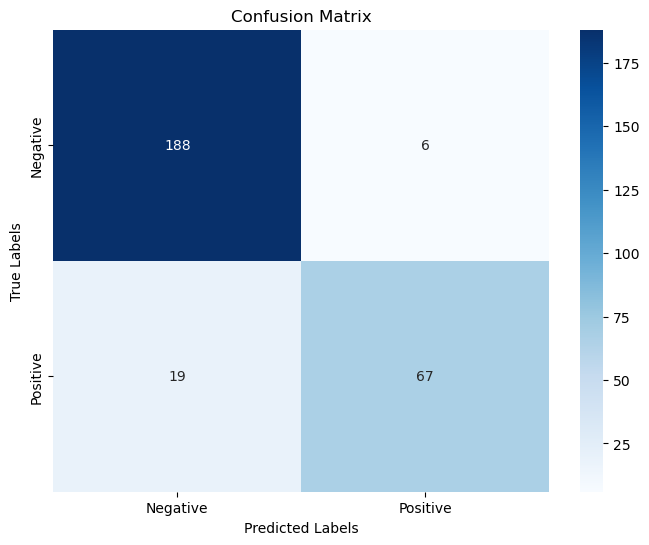

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['Comment']
y = df['Label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlm-roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
